# Assignment 4

This assignment is due Monday April 4th at 5pm. Please note: I will be out of town following our class on Thursday March 31 and won't return until after the assignment due date.  I won't be able to respond to email questions on this assignment unless they are sent before Sunday April 4 at 5pm.   Please use blackboard for uploading your completed assignment.  

I have uploaded all notebooks to the google drive site under the ``Notes`` folder.  The notebook beginning with the number 11 will be especially useful for completing this assignment.

** Note for MAC users **: If you have recently updated your computer and pymc3 isn't working anymore, please follow the instructions at the end of this thread to fix: https://github.com/Theano/Theano/issues/4277 


------
__Name__: Josh Klein

------

In this section, I would like for you to do a peer assessment of your collaborator (if you had one).  For the grade, please provide it on a 3 point scale (1 (my collaborator provided most of the intellectual input), 2 (we shared work equally), 3 (I provided most of the intellectual input).  Also, comment on your grade.

__Collaborator__ (if any, maximum of 2 people per team): Will Nisbet

__Grade for Collaborator__: 2 

__Comments__ :


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
from __future__ import division
import pymc3 as pm3
import statsmodels.formula.api as smf

np.random.seed(348348756)

sbn.set_style('white')
sbn.set_context('talk')

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Background and Review of Difference in Difference

We will be playing with data from a QJE paper from 1996, entitled "Labor Supply Response to the Earned Income Tax Credit" by Eissa and Liebman.  The paper can be found [here](http://www.hks.harvard.edu/jeffreyliebman/eissaliebmanqje.pdf).  The paper finds that single women with children, following the passage of the EITC, increased their labor force participation by 2.8%.

It is worthwhile reviewing difference in difference estimation for the impact of the policy.  The difference in difference (DID) estmate is
$$
E(\Delta y_{treatment}) - E(\Delta y_{control})
$$

It is worthwile thinking about two groups: treatment and control.  For this study, the breakdown between treatment and control is as follows:

|      |  Before 1993 | After 1993 |    
|:----:|:----:|:----:|
|Control| No Kids    | No Kids     |
|Treatment| Have Kids  |  Have Kids    |

Notice how we can use the dichotomy between time impacts on both the treatment and control groups to capture

* Changes in employment outcomes across all people from pre to post 1993 to account for economy wide fluctuations unrelated to EITC
* Difference between Control and Treatent before 1993 tells us about systematic differences between the two group unrelated to the EITC
* We can then combine these effects to find DID

Unfortunately, we don't have panel data.  We have different samples of people across time.  That is ok, specify the model like this:

$$
lfp_i = \beta_0 + \delta_0 post93_i + \beta_1 AnyKids_i + \delta_1 AnyKids_i \times post93_i + \mathbf{z}_i\gamma + \epsilon_i 
$$

For the purposes of making the following table readable, we will ignore the term $\mathbf{z}_i\gamma$ which captures how independent variables (like age, marital status, etc.) impact lfp.  So filling in the table, we can calculate $E(y_{treatment})$ and $E(y_{control})$ as

|      |  E(y) Before EITC (1993) | E(y) After EITC (1993) |    Difference |
|:----:|:----:|:----:|
|No Kids|  $\beta_0$    |   $\beta_0 + \delta_0$   | $\delta_0 $ |
|Have Kids| $\beta_0 + \beta_1 $  |  $\beta_0 + \delta_0 +\beta_1 + \delta_1 $ | $\delta_0 + \delta_1$ |
|Difference | $\beta_1$ | $\beta_1+ \delta_1$|$\delta_1$|

## Data and Results from Eissa and Liebman

In [2]:
eitc = pd.read_stata("http://rlhick.people.wm.edu/econ407/data/eitc.dta")

The data is

| Variable | Description |
|:------:|:--------|
| state | State identifier (assumed alphabetical) |
| year  | year of observation   |
| urate | state unemployment rate |
| children | number of children  |
| nonwhite | =1 if nonwhite, 0 otherwise |
| finc   | family income  |
| earn  | earned income  |
| age  | age of respondent |
| ed  | education level  |
| work | =1 if employed, 0 otherwise |
| unearn | unearned income  |

In [3]:
eitc.head()

,state,year,urate,children,nonwhite,finc,earn,age,ed,work,unearn
0,11,1991,7.6,0,1,18714.394273,18714.394273,26,10,1,0.000000
1,12,1991,7.2,1,0,4838.568282,471.365639,22,9,1,4.367203
2,13,1991,6.4,2,0,8178.193833,0.000000,33,11,0,8.178194
3,14,1991,9.1,0,1,9369.570485,0.000000,43,11,0,9.369570
4,15,1991,8.6,3,1,14706.607930,14706.607930,23,7,1,0.000000


In [4]:
eitc.describe()

,state,year,urate,children,nonwhite,finc,earn,age,ed,work,unearn
count,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000
mean,54.524590,1993.495117,6.761633,1.192638,0.600684,15255.319310,10432.475514,35.209661,8.806053,0.513022,4.822844
std,27.135209,1.709800,1.462461,1.382105,0.489776,19444.249684,18200.758138,10.157128,2.635639,0.499849,7.122624
min,11.000000,1991.000000,2.600000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000
25%,31.000000,1992.000000,5.700000,0.000000,0.000000,5123.417782,0.000000,26.000000,7.000000,0.000000,0.000000
50%,56.000000,1993.000000,6.800000,1.000000,1.000000,9636.664360,3332.179931,34.000000,10.000000,1.000000,2.973197
75%,81.000000,1995.000000,7.700000,2.000000,1.000000,18659.178178,14321.223709,44.000000,11.000000,1.000000,6.863863
max,95.000000,1996.000000,11.400000,9.000000,1.000000,575616.820870,537880.611850,54.000000,11.000000,1.000000,134.057520


In [5]:
# policy change occurs post 1993:
eitc['post_93'] = (eitc.year>1993).astype(int)
eitc['any_kids'] = (eitc.children>0).astype(int)

In [6]:
smf.ols('work~any_kids+post_93+post_93*any_kids+nonwhite+age',data=eitc).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   work   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     47.65
Date:                Sun, 03 Apr 2016   Prob (F-statistic):           4.91e-49
Time:                        12:51:51   Log-Likelihood:                -9853.9
No. Observations:               13746   AIC:                         1.972e+04
Df Residuals:                   13740   BIC:                         1.976e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            0.5582      0.019     29.121      0.000         0.521     0.596
any_kids            -0.1134      0.012     -9.468      0.000        -0.137    -0.090
post_93             -0.0006      0.013     -0.049      0.961        -0.026     0.025
post_93:any_kids     0.0492      0.017      2.872      0.004         0.016     0.083
nonwhite            -0.0648      0.009     -7.407      0.000        -0.082    -0.048
age                  0.0013      0.000      2.995      0.003         0.000     0.002
==============================================================================
Omnibus:                        6.155   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.046   Jarque-Bera (JB):             2136.597
Skew:                          -0.052   Prob(JB):                         0.00
Kurtosis:                       1.071   Cond. No.                         209.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In class, we estimated this same model using a heirarchical modeling approach.  To see if our findings are robust to specification changes:

### 1: Add or subtract independent variables to our in-class model

Continue to estimate a heirarchical model as we did in class (only the DID parameter is hierarchical) and respecify the model (add or subtract indepndent variables) in any way you'd like to see if the unobserved heterogeneity (and weak state-level impacts) for the impact of EITC continues to hold. Remember the goal is to see how robust our results are to better specifications.  Argue why your specification is better than mine.

In [ ]:
temp = eitc.groupby('state')['age'].mean()
state_lookup = temp.reset_index().drop('age',1).reset_index().rename(columns={'index':'state_index'})
eitc = pd.merge(eitc,state_lookup,how='left',on='state')
state_idx = eitc['state_index'].values.astype(int)
state_n = len(np.unique(state_idx))

In [34]:
smf.ols('work~any_kids+post_93+post_93*any_kids+nonwhite+age+earn+ed+urate',data=eitc).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   work   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     262.4
Date:                Mon, 04 Apr 2016   Prob (F-statistic):               0.00
Time:                        14:01:00   Log-Likelihood:                -8994.8
No. Observations:               13746   AIC:                         1.801e+04
Df Residuals:                   13737   BIC:                         1.808e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            0.3969      0.034     11.801      0.000         0.331     0.463
any_kids            -0.0604      0.011     -5.319      0.000        -0.083    -0.038
post_93             -0.0263      0.013     -2.053      0.040        -0.051    -0.001
post_93:any_kids     0.0341      0.016      2.118      0.034         0.003     0.066
nonwhite            -0.0320      0.009     -3.761      0.000        -0.049    -0.015
age                  0.0017      0.000      4.233      0.000         0.001     0.003
earn              9.037e-06   2.21e-07     40.824      0.000       8.6e-06  9.47e-06
ed                   0.0165      0.002     10.671      0.000         0.013     0.020
urate               -0.0190      0.003     -6.073      0.000        -0.025    -0.013
==============================================================================
Omnibus:                      115.575   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.897
Skew:                          -0.223   Prob(JB):                     2.51e-26
Kurtosis:                       2.914   Cond. No.                     1.82e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
hier_model_state = pm3.Model()

with hier_model_state:
    # hierarchical parent variables
    mu_treatment = pm3.Flat('Treatment Mean')
    sigma_treatment = pm3.HalfNormal('Treatment Sigma',sd = 20)
    # hierarchical children variables
    treatment = pm3.Normal('Treatment',mu = mu_treatment, sd=sigma_treatment,shape=state_n)
    
    # Non-Hierarchical Parameters
    intercept = pm3.Flat('Intercept')
    any_kids = pm3.Flat('Any Kids')
    post_93 = pm3.Flat('Post 1993')
    non_white = pm3.Flat('Non White')
    age = pm3.Flat('Age')
    earn = pm3.Flat('Earned Income')
    ed = pm3.Flat('Education')
    urate = pm3.Flat('Unemployment Rate')
    sigma = pm3.HalfNormal('Sigma',sd = 20)
    
    mu = intercept + any_kids*eitc.any_kids + post_93*eitc.post_93 + \
            non_white*eitc.nonwhite + age*eitc.age + \
            treatment[state_idx]*eitc.post_93*eitc.any_kids + \
            earn*eitc.earn + ed*eitc.ed + urate*eitc.urate
        
    like = pm3.Normal('Likelihood',mu=mu,sd=sigma,observed=eitc.work)

Applied log-transform to Treatment Sigma and added transformed Treatment Sigma_log to model.
Applied log-transform to Sigma and added transformed Sigma_log to model.


In [32]:
with hier_model_state:
    step = pm3.NUTS()
    trace_model_pre = pm3.sample(5000, step)

 [-----------------100%-----------------] 5001 of 5000 complete in 243.3 sec

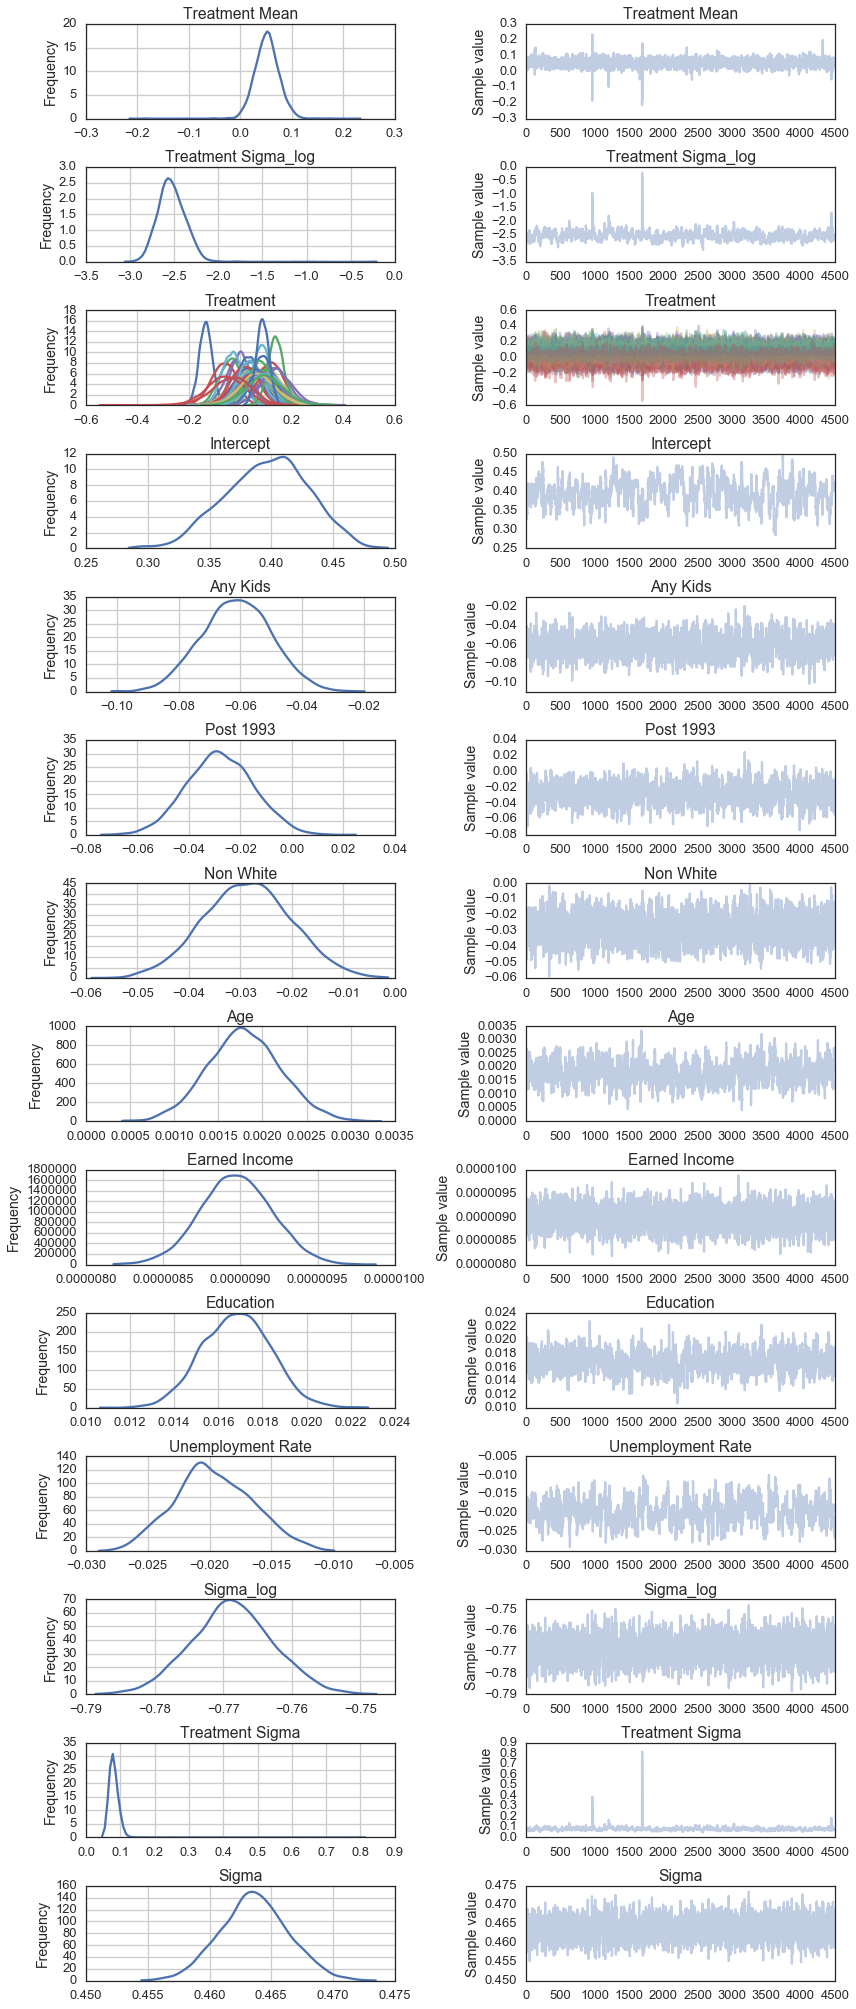

In [33]:
pm3.traceplot(trace_model_pre[500:]);

This model is preferable for several reasons. First of all, from the OLS estimate we see that this specification has a lower AIC/BIC than the original specification. It also makes sense that things like earned income, education level and state unemployment rate may affect working habits. Higher earned income may suggest the the marginal utility of working is higher so someone is more likely to work. Changes in education level may also change how people make choices about working or not working. Lastly, the state unemployment level will indicate the economic health of the state which may affect the way in which people choose to work.

### 2: Make your model a complete hierarchical model

Take the model you specified in the previous part and make ** all coefficients ** hierarchically grouped by state (e.g. there is a parent distribution across all states and for each of your slope coefficients the parameter is governed by the parent distribution). For $\mathbf{x}_k$ and state $s$:
\begin{align}
\mu_k \sim& Normal(\mu^0_\mu,\sigma^0_\mu)\\  
\sigma_k \sim& HalfNormal(\sigma^0_\sigma) \\
\mu^s_k \sim& Normal(\mu_k,\sigma_k)
\end{align}

In your work you should check for model convergence and unless noted otherwise focus your discussion on the DID estimate.


In [39]:
# The values for mu and sigma for the priors were taken from the OLS estimates of those values.
# This model was originally run with 5000 iterations but due to code errors it had to be rerun.
# For time reasons only 1000 iterations were used but the trace plots still indicate convergence.


hier_model_state = pm3.Model()

with hier_model_state:
    # hierarchical parent variables
    mu_treatment = pm3.Normal('Treatment Mean',mu = .0341, sd=0.016)
    sigma_treatment = pm3.HalfNormal('Treatment Sigma',sd = 20)
    mu_intercept = pm3.Normal('Intercept Mean',mu = 0.3969, sd=0.034)
    sigma_intercept = pm3.HalfNormal('Intercept Sigma',sd = 20)
    mu_any_kids = pm3.Normal('Any Kids Mean',mu = -0.0604, sd=0.011)
    sigma_any_kids = pm3.HalfNormal('Any Kids Sigma',sd = 20)
    mu_post_93 = pm3.Normal('Post 93 Mean',mu = -0.0263, sd=0.013)
    sigma_post_93 = pm3.HalfNormal('Post 93 Sigma',sd = 20)
    mu_non_white = pm3.Normal('Non White Mean',mu = -0.0320, sd=0.009)
    sigma_non_white = pm3.HalfNormal('Non White Sigma',sd = 20)
    mu_age = pm3.Normal('Age Mean',mu = 0.0017, sd=2.21e-07)
    sigma_age = pm3.HalfNormal('Age Sigma',sd = 20)
    mu_earn = pm3.Normal('Earned Income Mean',mu = 9.037e-06, sd=2.21e-07)
    sigma_earn = pm3.HalfNormal('Earned Income Sigma',sd = 20)
    mu_ed = pm3.Normal('Education Mean',mu = 0.0165, sd=0.002)
    sigma_ed = pm3.HalfNormal('Education Sigma',sd = 20)
    mu_urate = pm3.Normal('Unemployment Rate Mean',mu = -0.0190, sd=0.003)
    sigma_urate = pm3.HalfNormal('Unemployment Rate Sigma',sd = 20)
    
    # hierarchical children variables
    treatment = pm3.Normal('Treatment',mu = mu_treatment, sd=sigma_treatment,shape=state_n)
    intercept = pm3.Normal('Intercept',mu = mu_intercept, sd=sigma_intercept,shape=state_n)
    any_kids = pm3.Normal('Any Kids',mu = mu_any_kids, sd=sigma_any_kids,shape=state_n)
    post_93 = pm3.Normal('Post 93',mu = mu_post_93, sd=sigma_post_93,shape=state_n)
    non_white = pm3.Normal('Non White',mu = mu_non_white, sd=sigma_non_white,shape=state_n)
    age = pm3.Normal('Age',mu = mu_age, sd=sigma_age,shape=state_n)
    earn = pm3.Normal('Earned Income',mu = mu_earn, sd=sigma_earn,shape=state_n)
    ed = pm3.Normal('Education',mu = mu_ed, sd=sigma_ed,shape=state_n)
    urate = pm3.Normal('Unemployment Rate',mu = mu_urate, sd=sigma_urate,shape=state_n)
    sigma = pm3.HalfNormal('Sigma',sd = 20)
    
    mu = intercept[state_idx] + any_kids[state_idx]*eitc.any_kids + \
            post_93[state_idx]*eitc.post_93 + \
            non_white[state_idx]*eitc.nonwhite + age[state_idx]*eitc.age + \
            treatment[state_idx]*eitc.post_93*eitc.any_kids + \
            earn[state_idx]*eitc.earn + ed[state_idx]*eitc.ed + urate[state_idx]*eitc.urate
        
    like = pm3.Normal('Likelihood',mu=mu,sd=sigma,observed=eitc.work)

Applied log-transform to Treatment Sigma and added transformed Treatment Sigma_log to model.
Applied log-transform to Intercept Sigma and added transformed Intercept Sigma_log to model.
Applied log-transform to Any Kids Sigma and added transformed Any Kids Sigma_log to model.
Applied log-transform to Post 93 Sigma and added transformed Post 93 Sigma_log to model.
Applied log-transform to Non White Sigma and added transformed Non White Sigma_log to model.
Applied log-transform to Age Sigma and added transformed Age Sigma_log to model.
Applied log-transform to Earned Income Sigma and added transformed Earned Income Sigma_log to model.
Applied log-transform to Education Sigma and added transformed Education Sigma_log to model.
Applied log-transform to Unemployment Rate Sigma and added transformed Unemployment Rate Sigma_log to model.
Applied log-transform to Sigma and added transformed Sigma_log to model.


In [40]:
with hier_model_state:
    step = pm3.NUTS()
    trace_model_2 = pm3.sample(1000, step)

 [-----------------100%-----------------] 1001 of 1000 complete in 910.0 sec

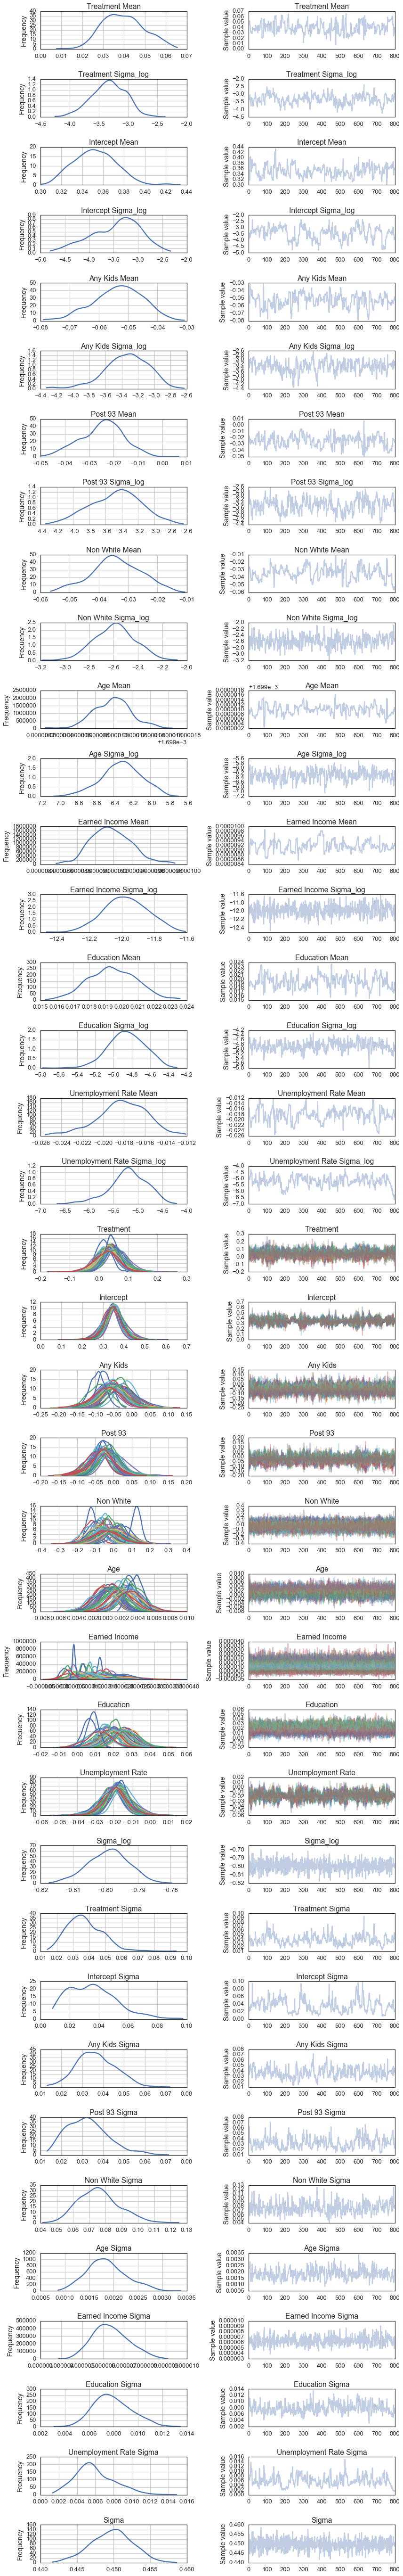

In [42]:
pm3.traceplot(trace_model_2[200:]);

(-50, 400)

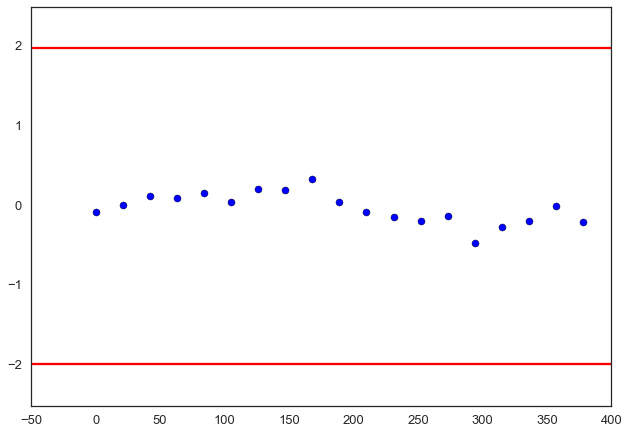

In [87]:
scores = pm3.geweke(trace_model_2[200:])
plt.scatter(scores['Treatment Mean'][:,0],scores['Treatment Mean'][:,1],s=50)

plt.axhline(-1.98, c='r')
plt.axhline(1.98, c='r')
plt.ylim(-2.5,2.5)
plt.xlim(-50,400)



The above is the Geweke plot for the parent treatment mean. The plot suggests that despite only having a chain length of 1000, we still have convergence. A visual inspection of the KDE and traceplots for the state level treatments suggest that we also have convergence in them. This allows us to progress with the analysis. We could check each parameter for convergence but given the complete hierarchy in the model, that would require looking at several hundred Geweke plots. Gelman-Rubin was not used due to the the time required to run multiple chains although once run this would allow for us to quickly check for convergence over many variables because we could write a loop to search for significant Gelman-Rubin values.

We would have similar trouble in checking autocorrelation plots.

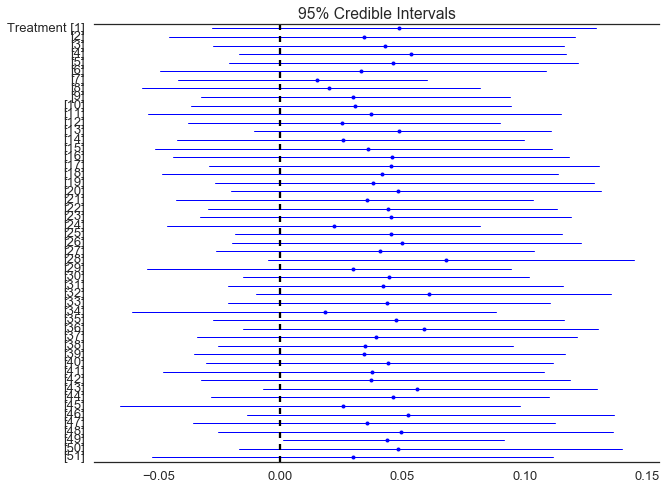

In [43]:
pm3.forestplot(trace_model_2[200:],quartiles=False,varnames=['Treatment']);

This plot shows credible intervals for the state level treatment effects.

Given your findings, what do you conclude about the impacts of EITC given this dataset?

The foresplot above suggests that we would expect the EITC to have positive impacts of the likelihood that people work. That being said, the credible intervals for all of the state level treatment effects contain 0 and negative values. That implies that there is some significant probability that the EITC would actually have no or a negative effect on employment in a state.